# Sturm Liouville decomposition gives some strange results

Looking at movies produced in the vs_compare notebook, we see that there appears to be an imprint of the first mode on the higher modes. To test I'll:

 - Make a Hovmöller of each mode along the centre of the beam. Check that angles match, suggesting that yes we do have multiple modes with the same phase speed
 - Check whether the stratification changes with time in the blank case. We average temporally, but in this case the stratification might not be stable as it's spinning up from the homogenous state

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask()
client

<Client: 'tcp://127.0.0.1:44691' processes=7 threads=28, memory=112.00 GiB>


<Client: 'tcp://127.0.0.1:44691' processes=7 threads=28, memory=112.00 GiB>

## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [28]:
trange = 50
to_process = {
    "full-20": {
        "data":tt.collect_data(
            exptname="full-20",
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).drop("cst").chunk({"zl":-1,"time":10}).persist()
        },
    "full-20-10000": {
        "data":tt.collect_data(
            exptname="full-20",
            rawdata = ["rho"],
            timerange = (10000,20000)
        )
        },
    # "full-20-20000": {
    #     "data":tt.collect_data(
    #         exptname="full-20",
    #         rawdata = ["rho"],
    #         timerange = (20000,30000)
    #     ).sel(yb = slice(-50,50))
    #     },
    # "ideal-20": {
    #     "data":tt.collect_data(
    #         exptname="ideal-20",
    #         rawdata = ["rho","u","v"],
    #         timerange = (1000 - trange,1000 + trange - 1)
    #     ).sel(yb = slice(-50,50))
    # }
    }

Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/120823087.gadi-pbs/ipykernel_2336824/45946287.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).drop("cst").chunk({"zl":-1,"time":10}).persist()


loading rho...	done.


## Try and smooth the density profile, and then pass through SL. See if this makes a difference

Currently my eigenfunctions are still using the entire water column. Find the depth of the mixed layer, use this to calculate local ~H

2.2364277777777777e-05
1.6339869281045753e-05


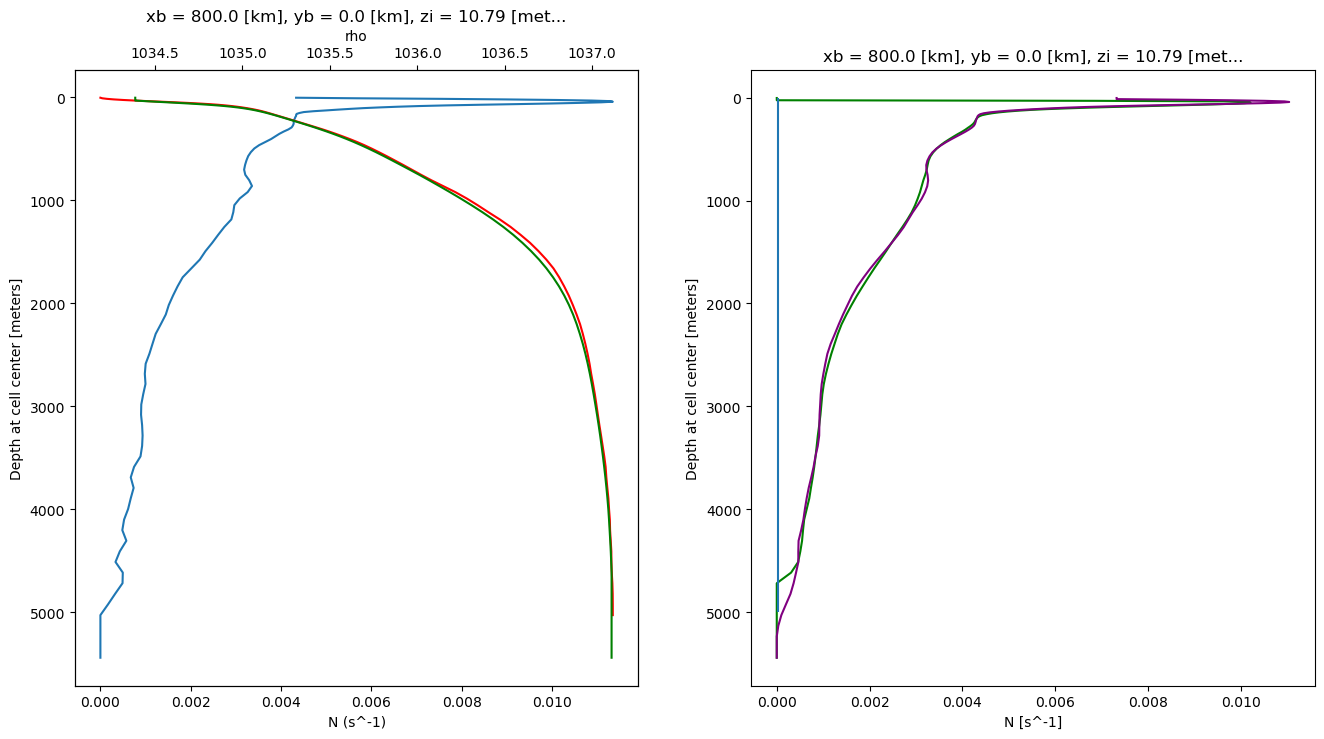

In [24]:
rho = to_process["ideal-20"]["data"].rho.sel(xb = 800,yb = 0,method = "nearest").mean("time").load()
rho_smooth = rho.rolling(zl = 10,center = True).mean().ffill("zl").bfill("zl")
N = tt.calculate_N(rho)
N_rmooth = tt.calculate_N(rho_smooth)
N_smoothed = N.rolling(zl = 5,center = True).mean().ffill("zl").bfill("zl")
M2 = (28.984104 / 360) / (3600)
f = 1/(17 * 3600)

fig,ax = plt.subplots(1,2,figsize = (16,8))
ax2 = ax[0].twiny()
# rho = to_process["ideal-20"]["data"].rho.sel(yb = 0,xb = x,method = "nearest").mean("time")
N.plot(y = "zl",ax = ax[0])
ax[0].set_title("")
ax[0].set_xlabel("N (s^-1)")
rho.plot(y = "zl",ax = ax2,color = "red")
ax[0].invert_yaxis()
ax[1].invert_yaxis()
rho_smooth.plot(y = "zl",ax = ax2,color = "green")
tt.calculate_N(rho_smooth).plot(y = "zl",ax = ax[1],color = "green")
N_smoothed.plot(y = "zl",ax = ax[1],color = "purple")
ax[1].vlines(M2,0,5000)
ax2
print(M2)
print(f)
# ax2.invert_yaxis()

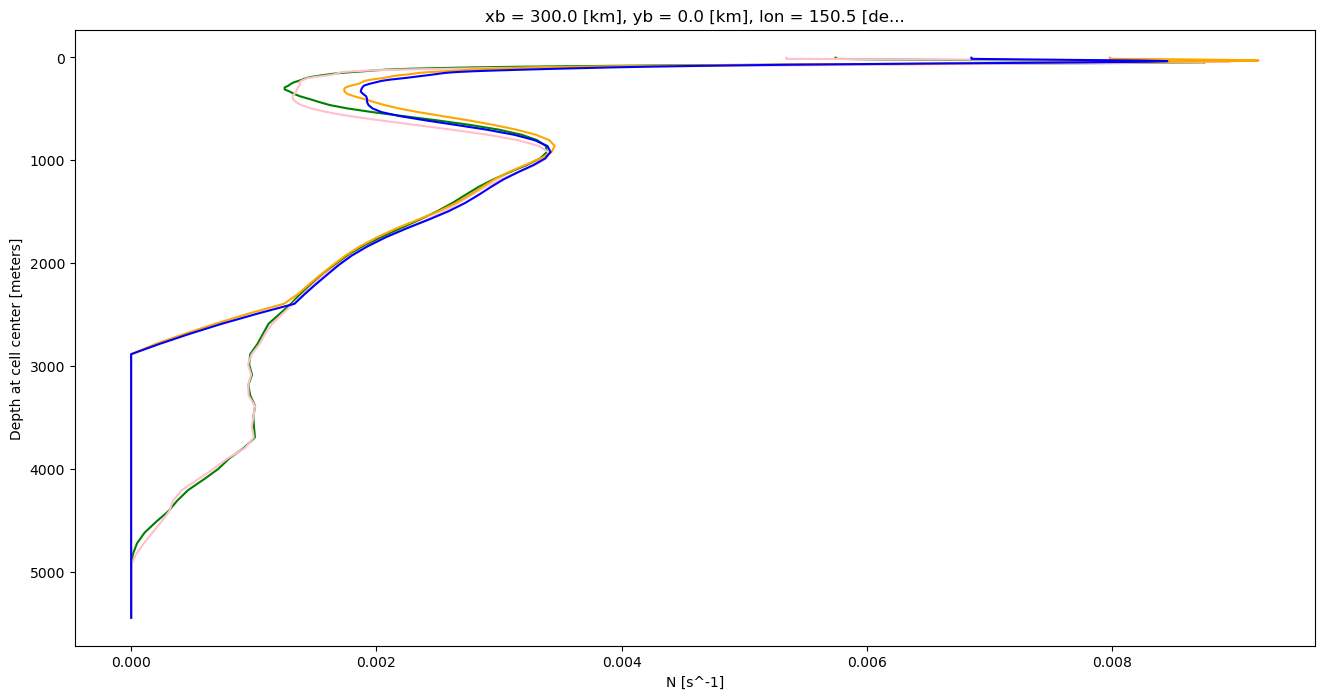

In [34]:
def getN(expt,x = 800):

    rhofull = to_process[expt]["data"].rho.sel(xb = x,yb = 0,method = "nearest").mean("time").load()
    Nfull = tt.calculate_N(rhofull)
    return Nfull.rolling(zl = 5,center = True).mean().ffill("zl").bfill("zl")

N10000 = getN("full-20-10000")
N20000 = getN("full-20-20000")
N10000_300 = getN("full-20-10000",x=300)
N20000_300 = getN("full-20-20000",x=300)

fig,ax = plt.subplots(figsize = (16,8))
# rho = to_process["ideal-20"]["data"].rho.sel(yb = 0,xb = x,method = "nearest").mean("time")
# Nideal.plot(y = "zl",ax = ax[1])
# Nfull.plot(y = "zl",ax = ax[0])
ax.set_title("")
ax.set_xlabel("N (s^-1)")
ax.invert_yaxis()
N10000.plot(y = "zl",ax = ax,color = "green")
N20000.plot(y = "zl",ax = ax,color = "pink")
N10000_300.plot(y = "zl",ax = ax,color = "orange")
N20000_300.plot(y = "zl",ax = ax,color = "blue")

# ax2.invert_yaxis()

## Try with shooting method

Need to iterate varying k until we match bv! Then figure out which other guesses get us other eigenfunctions 

## Put into a function to iteratively find k

Start at what we expect from mode 1, i.e

$ \huge m_n^2 \approx k_n^2 \frac{\overline{N}^2}{\omega_{M2}^2 - f^2} \approx \frac{\pi n}{H} $

$ \huge k_n^2 \approx \frac{2 \pi n(\omega_{M2}^2 - f^2)}{H \overline{N}^2} $

In [29]:
from scipy.optimize import fsolve
def knGuess(N,n):
    return np.pi * n / N.integrate("zl").values

def _iterator(k,soln = False,**kwargs):
    # print(k,end = "\t")

    N = kwargs["N"]
    z = N.zl.values

    #! Need to handle H!
    z = N.zl.values

    phi = np.zeros((2,z.size))
    x_plot = np.linspace(0, N.zl.values[-1], 100)
    sol = scipy.integrate.solve_bvp(
        lambda z,phi: fun(z,phi,k = k,N = N),
        bc,
        z,
        phi
        )
    y_plot = sol.sol(x_plot)[0]

    if soln:
        return sol

    # print(y_plot[-1])
    return y_plot[-1]


def bc(ya,yb):
    return np.array([ya[0],ya[1] - 0.05])

def fun(z,phi,**kwargs):
    k = kwargs["k"]
    N = kwargs["N"]
    Ninterp = N.interp(zl = z)
    NN = (Ninterp[0:len(z)]**2).values
    return np.vstack((phi[1],-k**2 * NN * phi[0]))

def ShootingVmodes(data,H = 5000,nmodes = 5):
    """
    Calculates vertical modes of both U and W. Fixes top boundary conditions as W(0) = 0, W'(0) = 1. Tweaks k until W(H) = 0.

    N : xarray.DataArray. Smoothed buoyancy frequency profile. Must be on the zl grid.
    H : float. Depth of the water column.
    nmodes : int. Number of modes to calculate.

    returns:
    xarray.Dataset containing U and W eigenfunctions 
    """
    ## First need to handle for the case where we're running this on 3D data rather than single water column!
    # data = data.drop_vars(["xb","yb"])

    N = data.N.isel(xb = 0,yb = 0).drop_vars(["xb","yb"])
    H = data.H.isel(xb = 0,yb = 0).drop_vars(["xb","yb"]).values


    # N is on the zl grid. First add surface and seafloor values.
    N_trunc = N.sel(zl = slice(0,H))
    N_extend = np.zeros(N_trunc.shape[0] + 2)
    z_extend = np.zeros(N_extend.shape[0])
    z_extend[1:len(z_extend) - 1] = N_trunc.zl.values
    N_extend[1:len(z_extend) - 1] = N_trunc.values
    N_extend[0] = N_extend[1]
    N_extend[-1] = N_extend[-2]
    z_extend[0] = 0
    z_extend[-1] = H

    N_extend = xr.DataArray(N_extend,dims = "zl",coords = {"zl":z_extend})
    f,M2 = 1/(17 * 3600), (28.984104 / 360) / (3600)

    # Now N spans the entire water column allowing for accurate boundary conditions
    if not N_extend.integrate("zl") == 0: ## Check the case that N is zero, need to return dummy value in this case
        ks = [
            fsolve(
            lambda x:_iterator(x,soln = False,N = N_extend),
            [knGuess(N_extend,i)]
        )[0] for i in range(1,nmodes+1)]

        efuncs = []
        W = (N * 0).expand_dims({"mode":nmodes})
        for i,k in enumerate(ks):
            soln = _iterator(k,soln = True,N = N_extend)
            Weigenfunc = xr.DataArray(
                soln.sol(soln.x)[0],
                dims = ["z_l"],
                coords = {"z_l":soln.x}
            )
            Weigenfunc = Weigenfunc / (np.sqrt((Weigenfunc**2).integrate("z_l")))

            # Ueigenfunc = Weigenfunc.differentiate("z_l").interp(z_l = N_trunc.zl.values).rename({"z_l":"zl"})
            Ueigenfunc = Weigenfunc.differentiate("z_l").interp(z_l = N.zl.values).fillna(0).rename({"z_l":"zl"})
            Ueigenfunc = Ueigenfunc / (np.sqrt((Ueigenfunc**2).integrate("zl")))


            ## Now calculate the actual k from dispersion relation. Divide by sqrt(M2^2 - f^2)
            
            k *= np.sqrt(M2**2 - f**2)
            h_wavelength = Ueigenfunc.isel(zl = 0).drop_vars(["zl"]).rename("Wavelength") * 0 + 1e-3/k 

            efuncs.append(xr.merge([Weigenfunc.rename("W"),Ueigenfunc.rename("U"),h_wavelength]).assign_coords({"mode":i}).expand_dims("mode"))


        efuncs = xr.concat(efuncs,dim = "mode")
        efuncs.mode.attrs["units"] = "km"
        efuncs.mode.attrs["short name"] = "Horizontal wavelength"
        # assert "xb" not in efuncs
        efuncs = efuncs.expand_dims({"xb":data.xb.values,"yb":data.yb.values})
        # These efuncs now contain polynomial spline objects. 
        # They should be used to generate both the vertical and horizontal eigenfunctions zi and zl points

        return efuncs[["U","Wavelength"]].transpose("mode","zl","yb","xb")
    
    else:
        ## In this case we return a dummy values with the right shape
        Ueigenfunc = xr.DataArray(
            N.zl.values * 0,
            dims = ["zl"],
            coords = {"zl":N.zl.values}
        ).rename("U").expand_dims({"xb":data.xb.values,"yb":data.yb.values,"mode":np.arange(nmodes)}).transpose("mode","zl","yb","xb")
        h_wavelength = Ueigenfunc.isel(zl = 0).drop_vars(["zl"]).rename("Wavelength")
        return xr.merge([Ueigenfunc,h_wavelength])

def ShootingVmodes_parallel(data,nmodes = 5):
    # N = N.chunk({"xb":1,"yb":1})
    # H = H.chunk({"xb":1,"yb":1})
    if len(data.zl) == 0:
        return data
    # print(data)
    vmode_template = data.N.expand_dims({"mode":np.arange(5)}).rename("U").drop_vars(["lat","lon"])
    wavenumber_template = vmode_template.isel(zl = 0).drop_vars(["zl"]).rename("Wavelength")
    template = xr.merge([vmode_template,wavenumber_template])
    return xr.map_blocks(
        ShootingVmodes,
        data,kwargs = {"nmodes":nmodes},
        template = template
    )
def getN(rho):

    rhofull = rho
    Nfull = tt.calculate_N(rhofull)
    return Nfull.rolling(zl = 5,center = True).mean().ffill("zl").bfill("zl")
# N = getN(to_process["full-20-10000"]["data"].rho).sel(xb = slice(200,1200),yb = slice(-50,50)).mean("time").load()
# H = -1 * to_process["full-20"]["data"].bathy.sel(xb = slice(200,1200),yb = slice(-50,50))

N = getN(to_process["full-20-10000"]["data"].rho).mean("time").load()
H = -1 * to_process["full-20"]["data"].bathy

# N = getN(to_process["full-20-10000"]["data"].rho).sel(xb = slice(200,205),yb = slice(-5,5)).mean("time").load()
# H = -1 * to_process["full-20"]["data"].bathy.sel(xb = slice(200,205),yb = slice(-5,5))

data = xr.merge([N.rename("N"),H.rename("H")]).load()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return fu

In [30]:
data_chunked = data.chunk({"xb":1,"yb":1,"zl":-1})
print("Decomposing:")
parallel = ShootingVmodes_parallel(data_chunked,nmodes = 5).load()

parallel.to_netcdf("/g/data/nm03/ab8992/postprocessed/full-20/vertical_modes_fulldom.nc")


parallel
parallel.U.isel(mode = 3,yb = 2).plot()


Decomposing:


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 71.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/jobfs/120823087.gadi-pbs/ipykernel_2336824/1766968783.py:76: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.


: 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 11.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


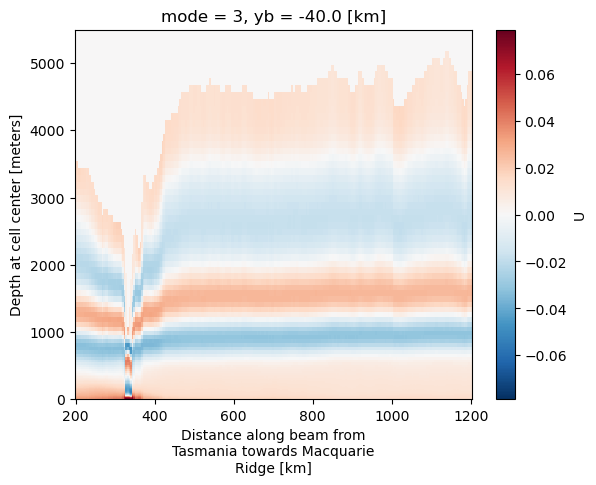

In [16]:
data_chunked = data.chunk({"xb":1,"yb":1,"zl":-1})
print("Decomposing:")
parallel = ShootingVmodes_parallel(data_chunked,nmodes = 5).load()

parallel.to_netcdf("/g/data/nm03/ab8992/postprocessed/full-20/vertical_modes_fulldom.nc")


parallel
parallel.isel(mode = 3,yb = 2).plot()


## Use the eigenfunctions run overnight

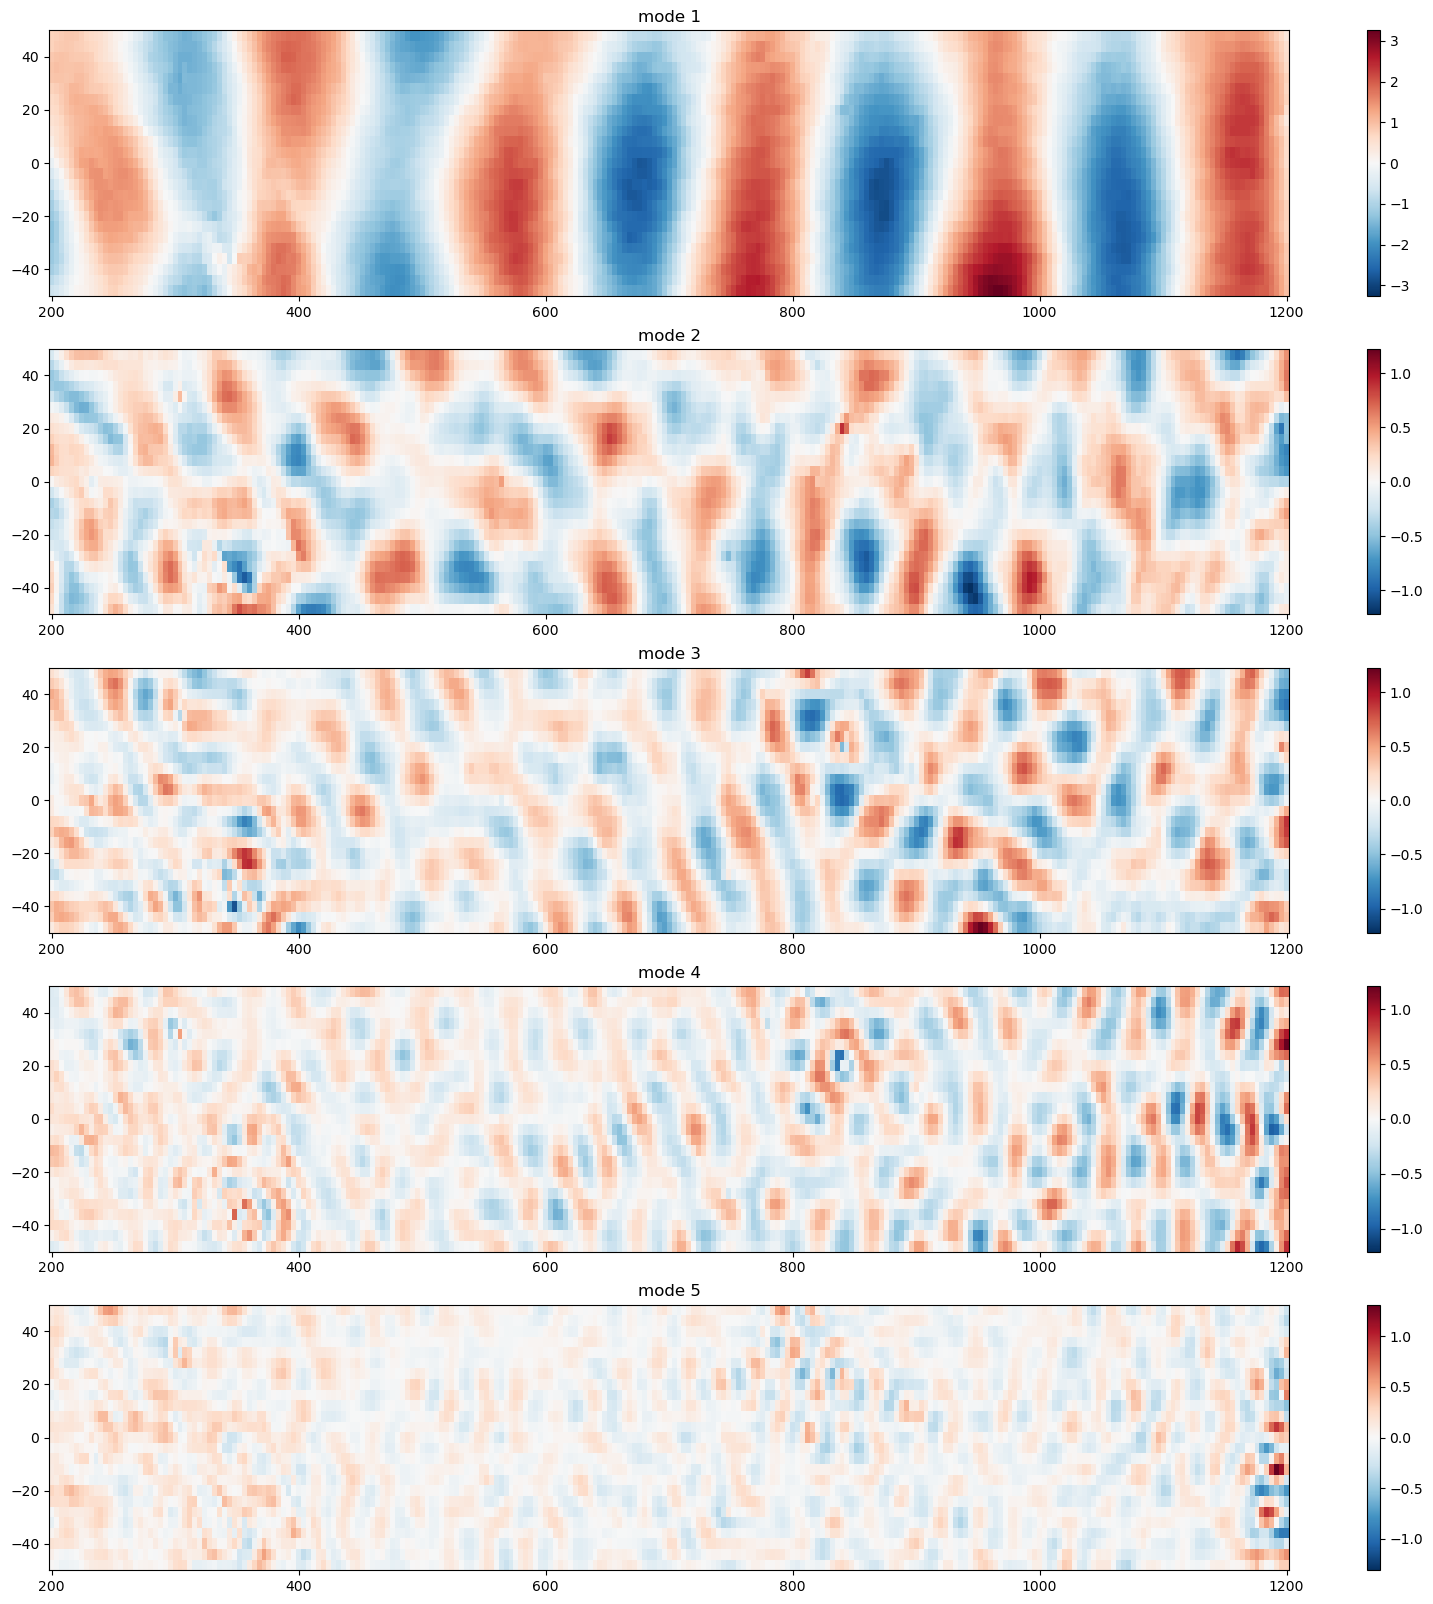

In [6]:
eigfs = xr.open_dataset("/g/data/nm03/ab8992/postprocessed/full-20/vertical_modes_fulldom.nc")
# print(eigfs)
fig,ax = plt.subplots(5,figsize = (20,20))
for i in range(5):
    u = (eigfs.U.isel(mode = i) * to_process["full-20"]["data"].isel(time = 50).u).sel(xb = slice(200,1200)).integrate("zl")
    u.plot(ax = ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(f"mode {i + 1}")

## Run the whole domain overnight

In [17]:
N = getN(to_process["full-20-10000"]["data"].rho).mean("time")
H = -1 * to_process["full-20"]["data"].bathy
datax = xr.merge([N.rename("N"),H.rename("H")]).load()

data = datax.chunk({"xb":1,"yb":1,"zl":-1})


parallel = ShootingVmodes_parallel(data,nmodes = 5).load()

parallel.to_netcdf("/g/data/nm03/ab8992/postprocessed/full-20/vertical_modes_full.nc")


parallel
parallel.isel(mode = 3,yb = 2).plot()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in sqrt
  return fu

ValueError: `x` must be strictly increasing.

/jobfs/120489698.gadi-pbs/ipykernel_3666842/1869812110.py:17: RuntimeWarning: divide by zero encountered in divide
2024-07-10 21:37:49,198 - distributed.worker - WARNING - Compute Failed
Key:       ('ShootingVmodes-<this-array>-ShootingVmodes-a78952537be6f444b74d8756bd1f59de', 0, 0, 10, 0)
Function:  execute_task
args:      ((<built-in function getitem>, (<function map_blocks.<locals>._wrapper at 0x149f41c757e0>, <function ShootingVmodes at 0x149f41c745e0>, [(<class 'xarray.core.dataset.Dataset'>, (<class 'dict'>, [['N', (('zl', 'yb', 'xb'), array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

    

In [118]:
template = datax.N.expand_dims({"mode":np.arange(5)}).rename("U").drop_vars(["lat","lon"])

In [82]:
out.H.values

array([[-9364.40071084, -9469.32612968, -9437.0001172 , -9365.16880781,
        -9323.90250306, -9359.9984987 , -9465.66820099, -9534.44940797,
        -9612.06443863, -9675.56927384, -9693.11045244, -9621.1727815 ,
        -9650.59427477, -9668.59859883, -9636.58684152, -9549.64877297,
        -9467.02574246, -9444.14301216, -9373.38634301, -9312.98967577,
        -9260.53991055, -9285.39563823, -9361.30257349, -9438.84647173,
        -9515.40513855, -9588.08297026],
       [-9453.74357782, -9446.28323222, -9365.83552593, -9229.8700727 ,
        -9035.20090883, -9075.63635684, -9299.52300627, -9425.32251264,
        -9492.40881732, -9475.21340774, -9454.98470958, -9453.46240248,
        -9574.73585636, -9712.78135516, -9796.16577199, -9794.8385863 ,
        -9716.5998356 , -9556.66547336, -9409.36984031, -9281.89095645,
        -9217.10245056, -9240.12934978, -9312.53803025, -9410.38461154,
        -9539.61038021, -9661.29659972],
       [-9397.40285214, -9289.90600462, -9107.88580795

In [11]:
f,M2 = 1/(17 * 3600), (28.984104 / 360) / (3600)
print(f,M2)


1.6339869281045753e-05 2.2364277777777777e-05


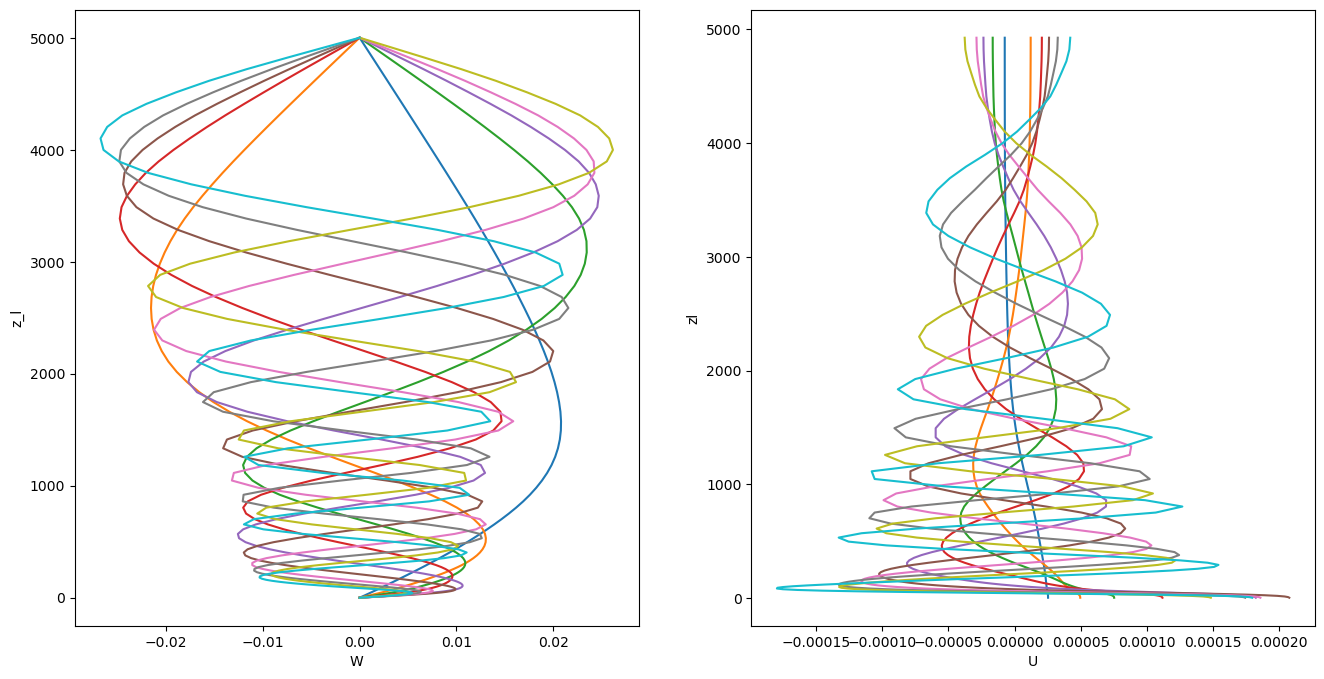

In [80]:



efuncs = ShootingVmodes(N,5000,nmodes = 10)
fig,ax = plt.subplots(1,2,figsize = (16,8))
for k in efuncs:
    efuncs[k].W.plot(y = "z_l",ax = ax[0])
    efuncs[k].U.plot(y = "zl",ax = ax[1])

In [82]:
k

3.5200022923326793

## Make top down plots of this eigendecomposition

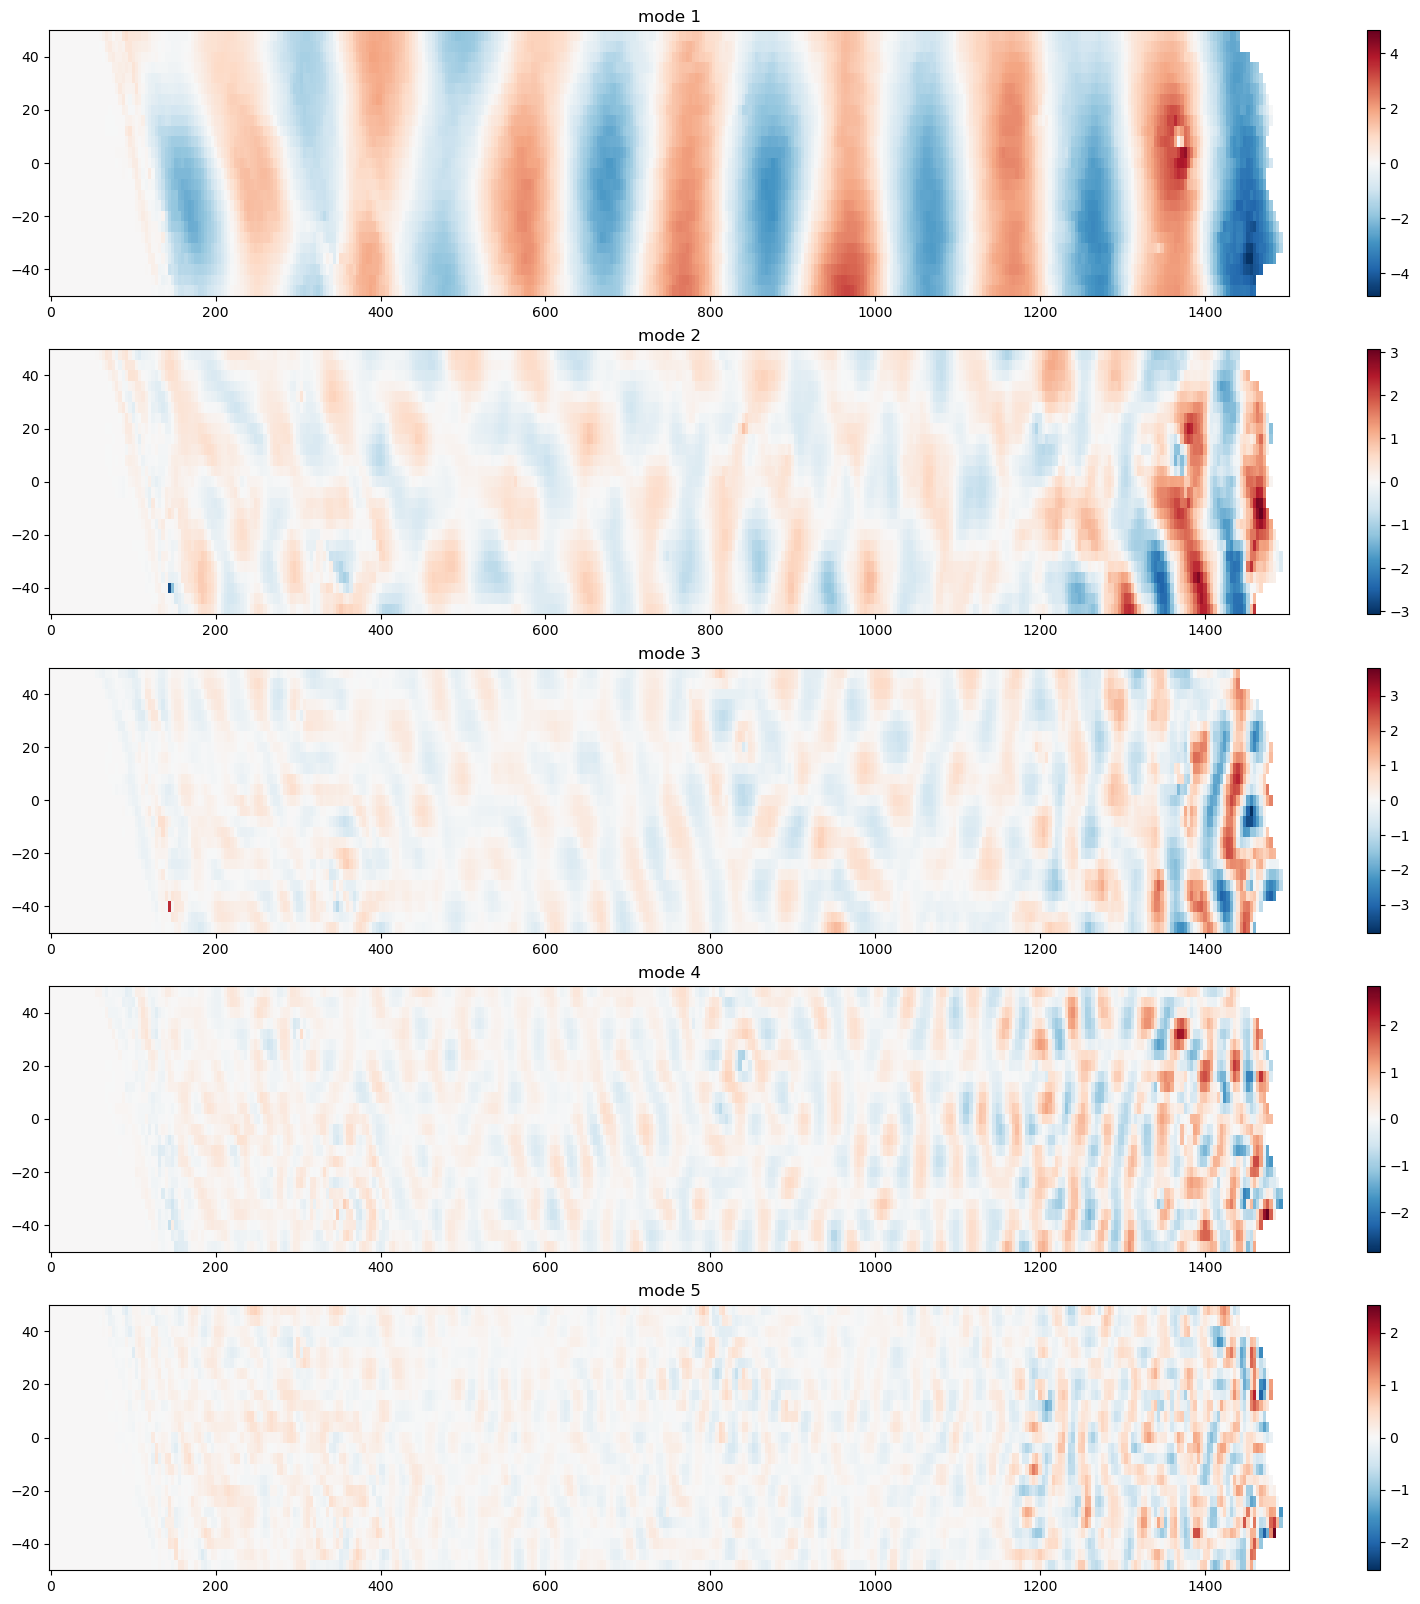

In [22]:
fig,ax = plt.subplots(5,figsize = (20,20))
efuncs = parallel.U
for i in range(5):
    u = (efuncs.isel(mode = i) * to_process["full-20"]["data"].isel(time = 50).u).integrate("zl")
    u.plot(ax = ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(f"mode {i + 1}")

    # ax[i].vlines(1200 - (1/k))



In [27]:
def proficiency_fraction(x):
    if 1 <= x <= 10:
        numerator = 10 - x
        fraction = f"{numerator} / 10"
        print(fraction)
    else:
        print("x must be between 1 and 10.")

# Example usage
proficiency_fraction(3)

7 / 10


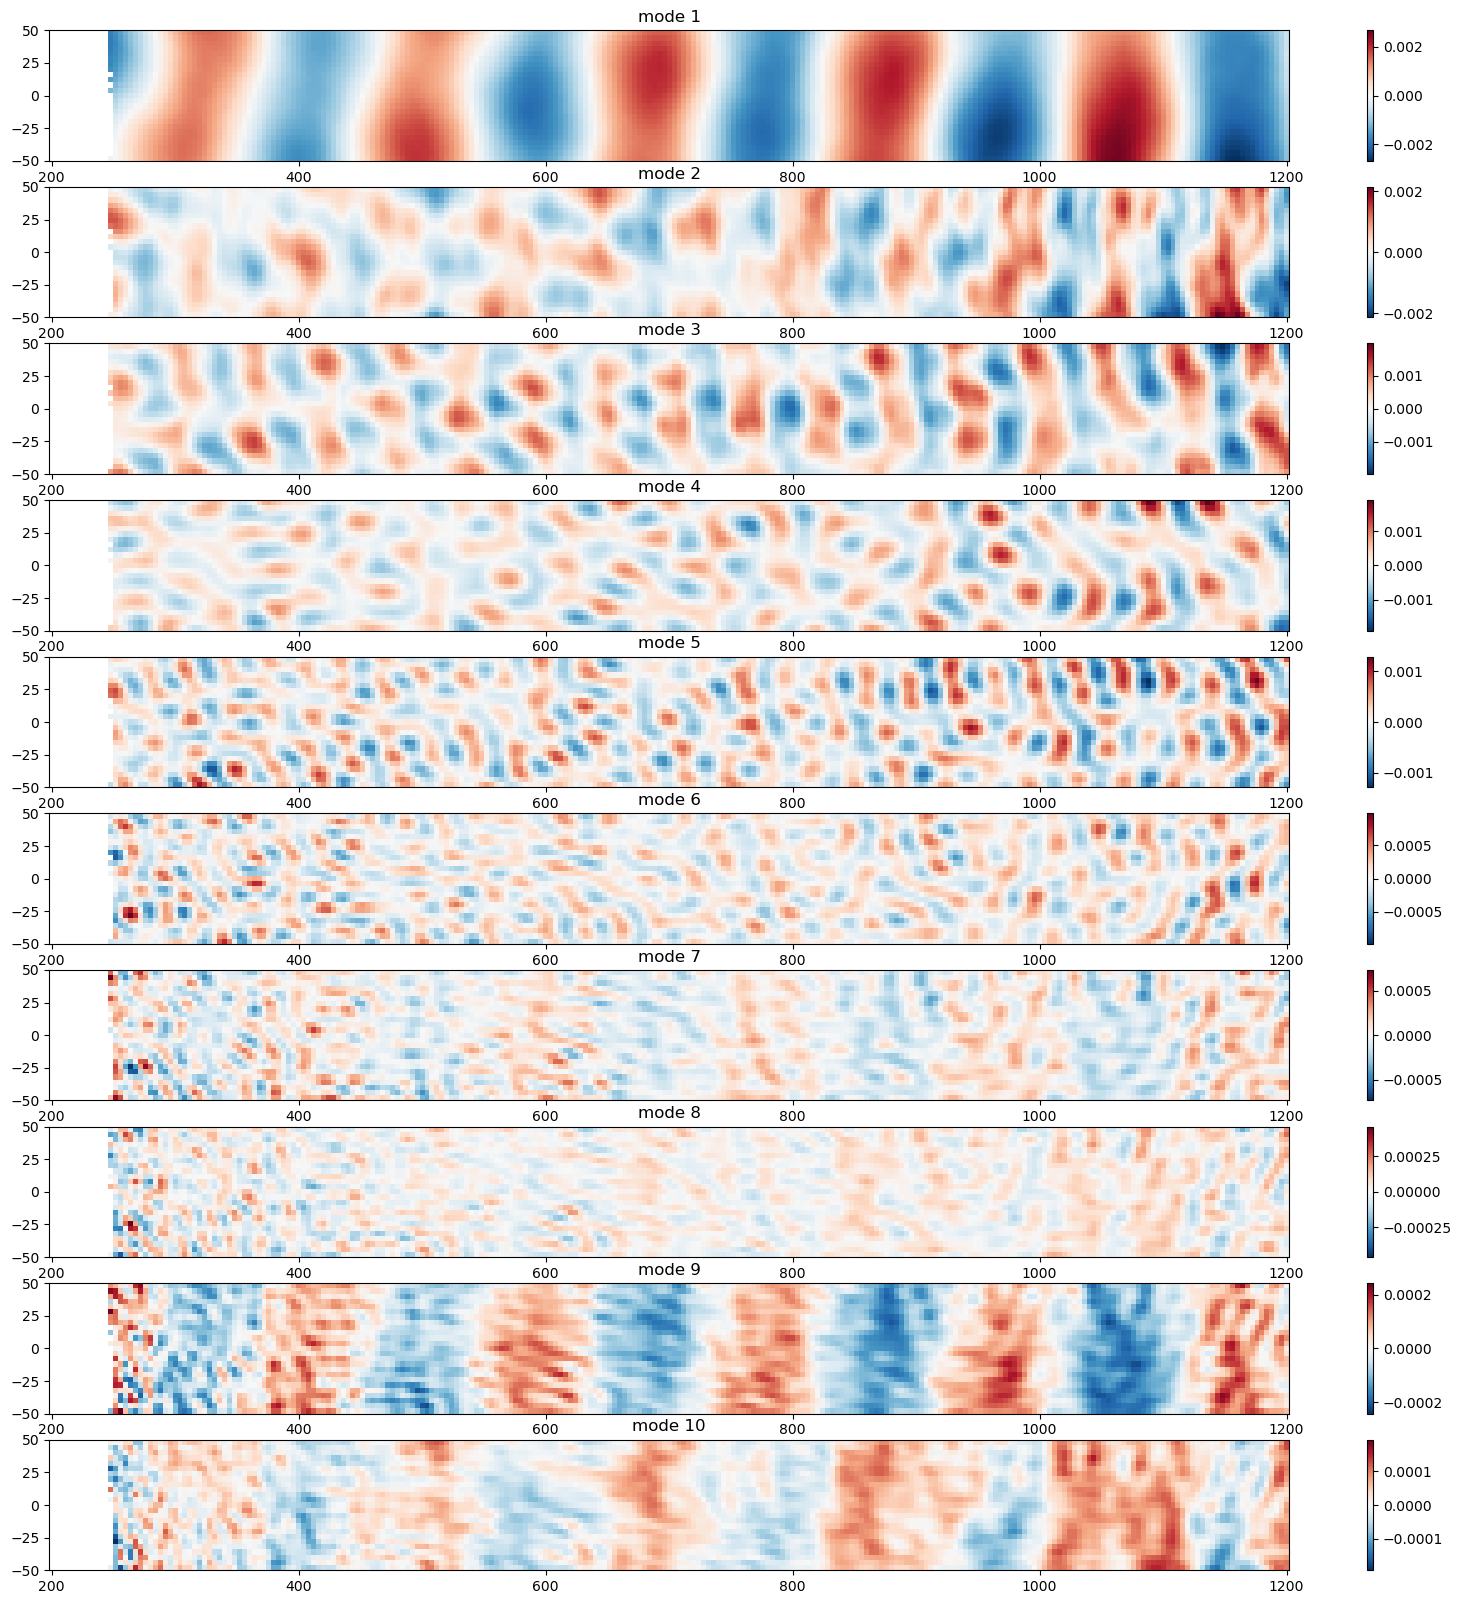

In [39]:
fig,ax = plt.subplots(10,figsize = (20,20))
for i in range(10):
    u = (efuncs.U.isel(mode = i) * to_process["ideal-20"]["data"].isel(time = 50).u).sel(xb = slice(200,1200)).integrate("zl")
    u.plot(ax = ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(f"mode {i + 1}")

    # ax[i].vlines(1200 - (1/k))



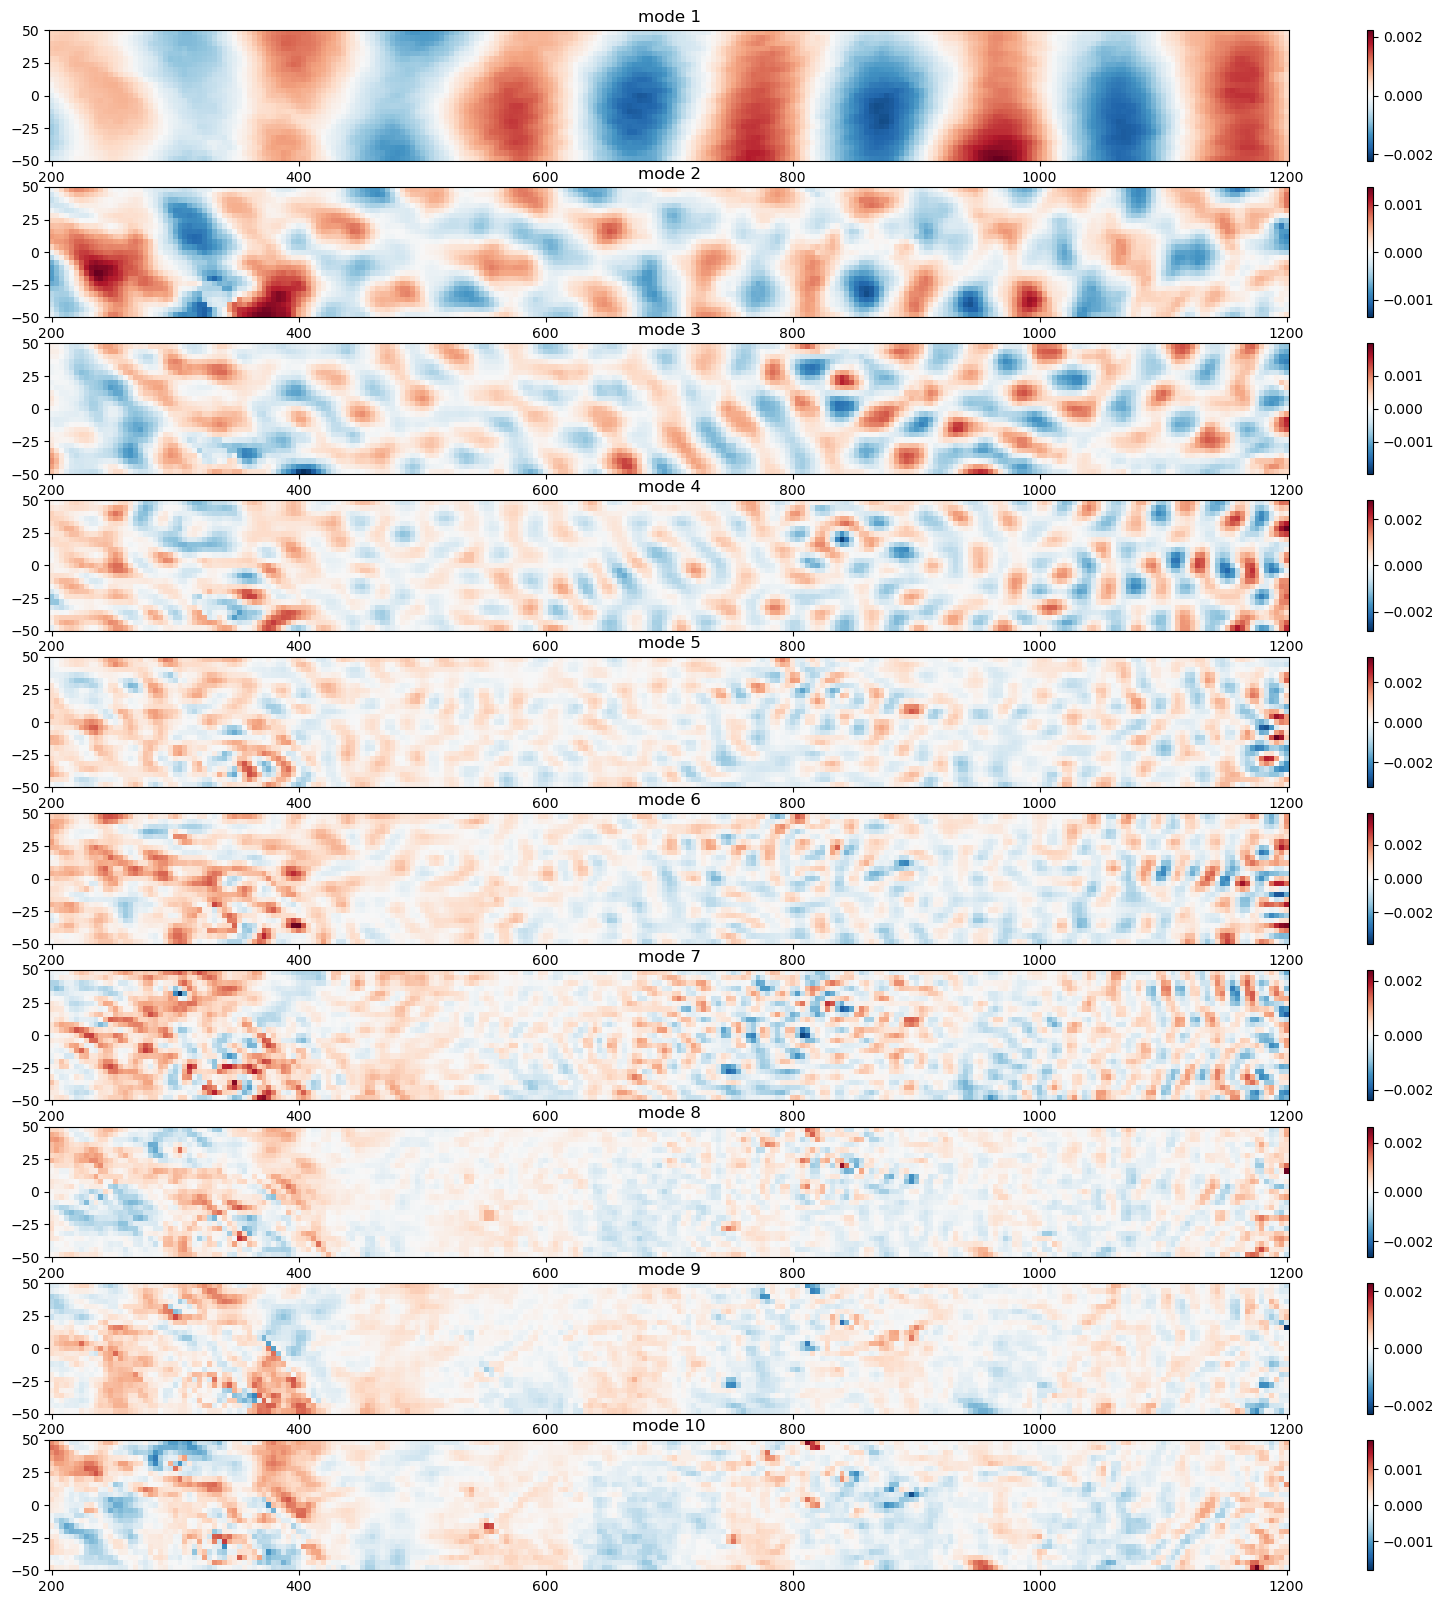

In [40]:
fig,ax = plt.subplots(10,figsize = (20,20))
for i in range(10):
    u = (efuncs_full.U.isel(mode = i) * to_process["full-20"]["data"].isel(time = 50).u).sel(xb = slice(200,1200)).integrate("zl")
    u.plot(ax = ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(f"mode {i + 1}")

    # ax[i].vlines(1200 - (1/k))



ValueError: shape mismatch: value array of shape (1, 25, 376) could not be broadcast to indexing result of shape (0, 25, 376)

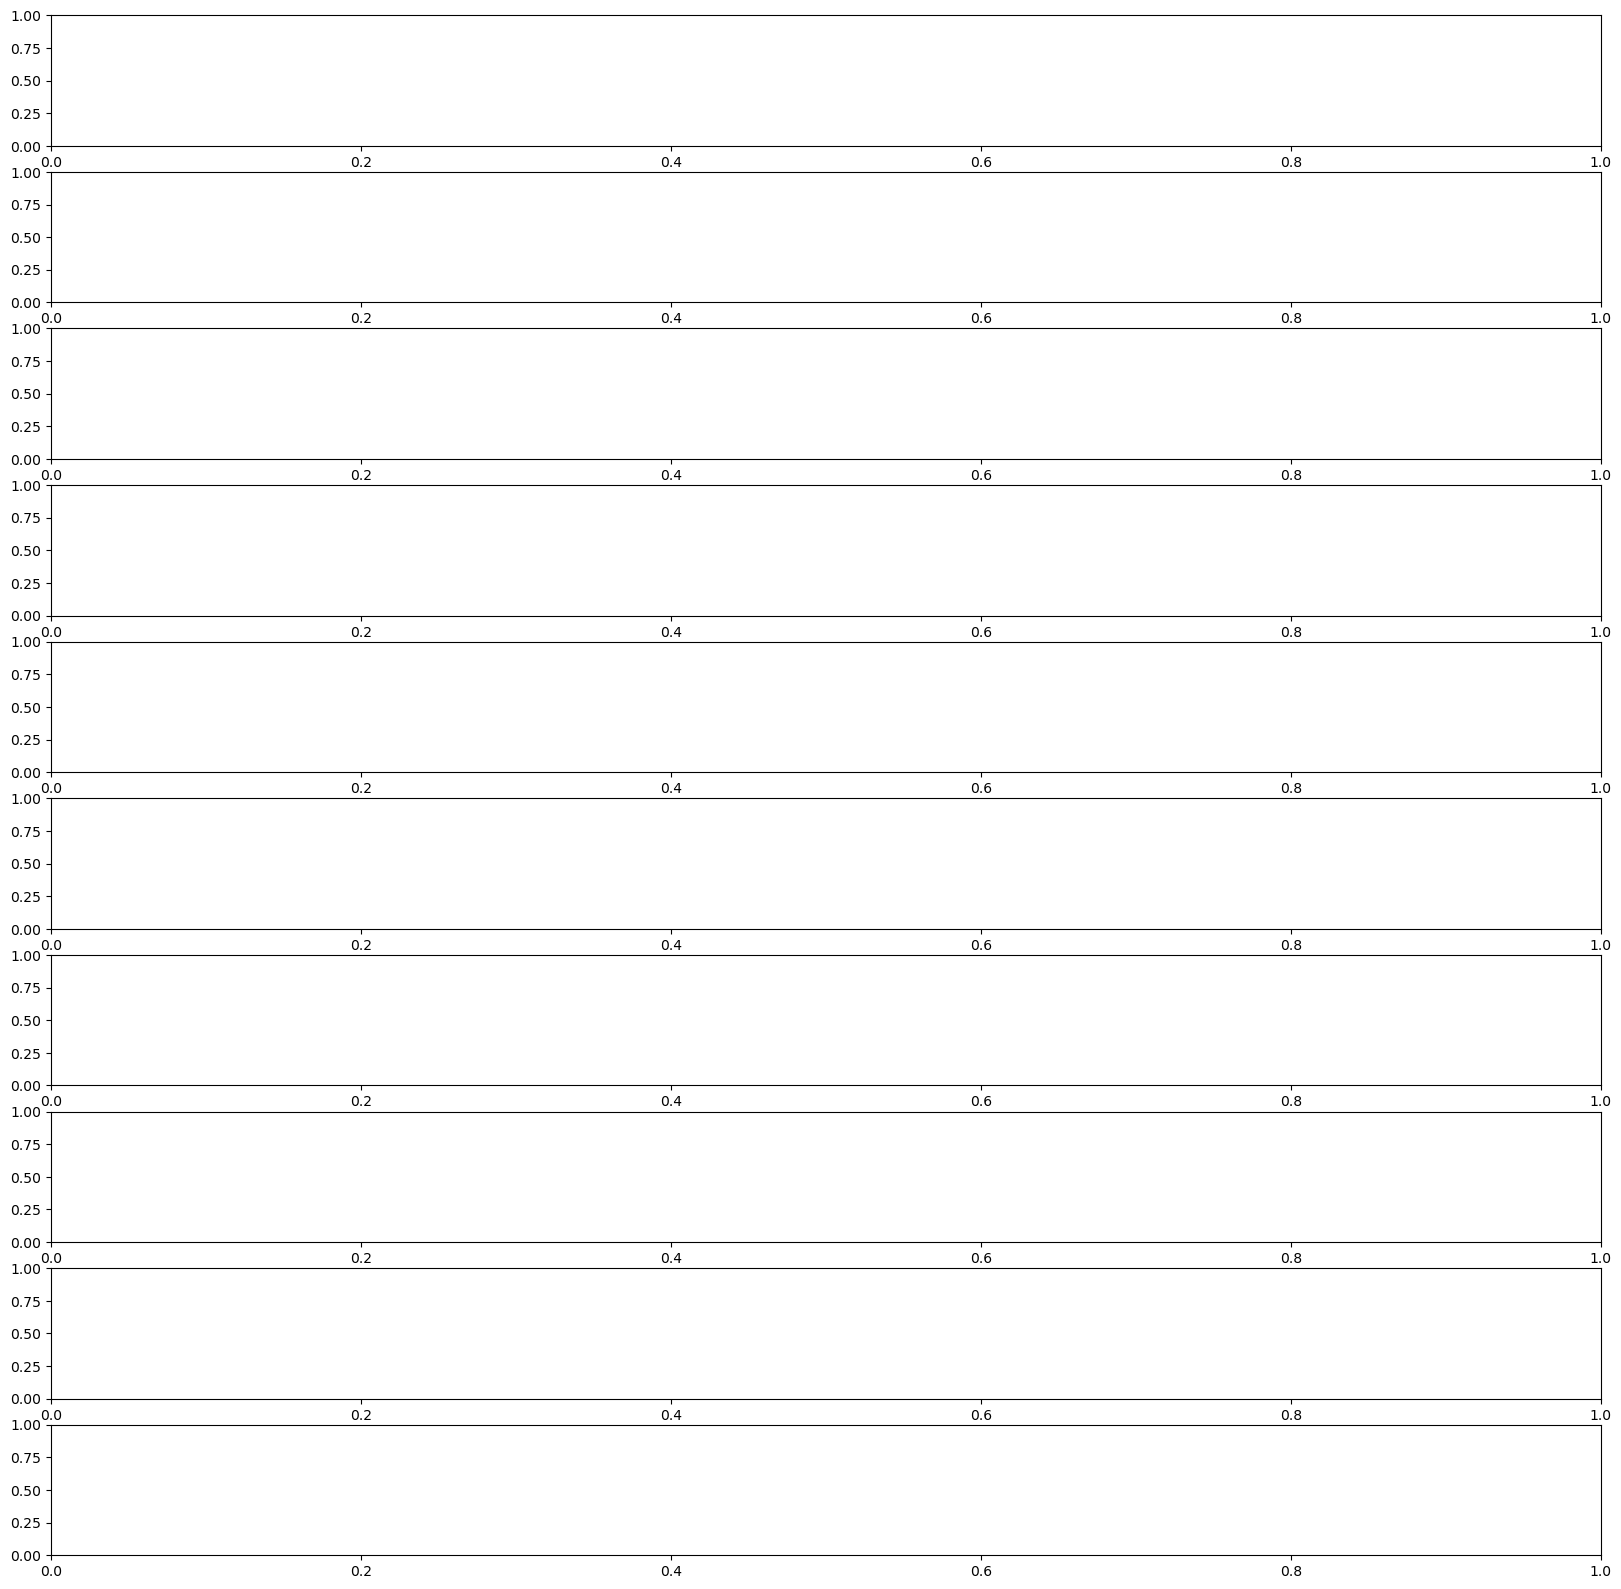

In [87]:
fig,ax = plt.subplots(10,figsize = (20,20))
mllimit = 0
u_removemixed = to_process["full-20"]["data"].isel(time = 50).u
u_removemixed.loc[u_removemixed.zl < mllimit] = u_removemixed.sel(zl = mllimit,method = "nearest")
for i,k in enumerate(efuncs):
    u
    u = (efuncs[k].U * u_removemixed).sel(xb = slice(200,1200)).integrate("zl")
    u.plot(ax = ax[i])
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(f"mode {i + 1}")

In [ ]:
fig,ax = plt.subplots(5,2,figsize = (20,20))
for i in range(5):
    vmodesSmoothRemoveMixed.u.isel(mode=0).sel(xb =slice(0,1200)).sel(yb = 0,method = "nearest").plot.contour(levels = [0],ax= ax[i,0],cmap = "black")
    filtered_vmodes.isel(mode=0).sel(yb = 0,method = "nearest").plot.contour(levels = [0],ax= ax[i,1],cmap = "black")

    # filtered = (ufiltered * vmodes.phi).sel(xb =slice(0,1200)).sel(yb = 0,method = "nearest")

    vmodesSmoothRemoveMixed.u.isel(mode=i).sel(xb =slice(0,1200)).sel(yb = 0,method = "nearest").plot(ax= ax[i,0])
    filtered_vmodes.isel(mode=i).sel(yb = 0,method = "nearest").plot(ax= ax[i,1])
    ax[i,0].set_xlabel("")
    ax[i,0].set_title(f"full mode {i}")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("")
    ax[i,1].set_title(f"homogenous N mode {i}")
    ax[i,1].set_ylabel("")

fig.suptitle("Contours of mode 1 overlaid on higher mode. It's clear that mode 1 modulates the higher modes!")

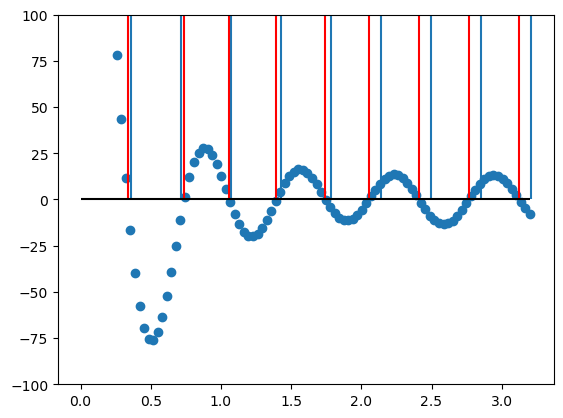

In [38]:
from scipy.optimize import fsolve

ks = [
    fsolve(
    lambda x:_iterator(x,soln = False,N = N),
    [knGuess(N,i)]
) for i in range(1,10)]
x = np.linspace(0,3.2,100)
y = [i for i in map(lambda x:_iterator(x,soln = False,N = N),x)]

plt.scatter(x,y)
plt.vlines([knGuess(N,i) for i in range(1,10)],0,100)
plt.vlines([k for k in ks],0,100,color = "red")
plt.ylim(-100,100)
plt.hlines(0,0,3.2,color = "black")

In [ ]:
fig,ax = plt.subplots(1,3,figsize = (16,8))
H = to_process["ideal-20"]["data"].H.sel(xb = 800,yb = 0,method = "nearest")
for i in range(5):
    vmodes.phi.sel(xb = 800,yb = 0,method = "nearest").isel(mode = i).sel(zl = slice(0,H)).plot(ax = ax[0],y = "zl")
    vmodesSmooth.phi.sel(xb = 800,yb = 0,method = "nearest").isel(mode = i).sel(zl = slice(0,H)).plot(ax = ax[1],y = "zl")
    vmodesSmoothRemoveMixed.phi.sel(xb = 800,yb = 0,method = "nearest").isel(mode = i).sel(zl = slice(0,H)).plot(ax = ax[2],y = "zl")
ax[0].set_title("Raw N")
ax[1].set_title("Smoothed N")
ax[2].set_title("Smoothed N, remove mixed")
ax[0].set_ylim(0,H)
ax[2].set_ylim(0,H)
ax[1].set_ylim(0,H)
ax[2].set_ylim(0,H)
ax[0].hlines(30,-0.05,0.05,color = "black")

: 

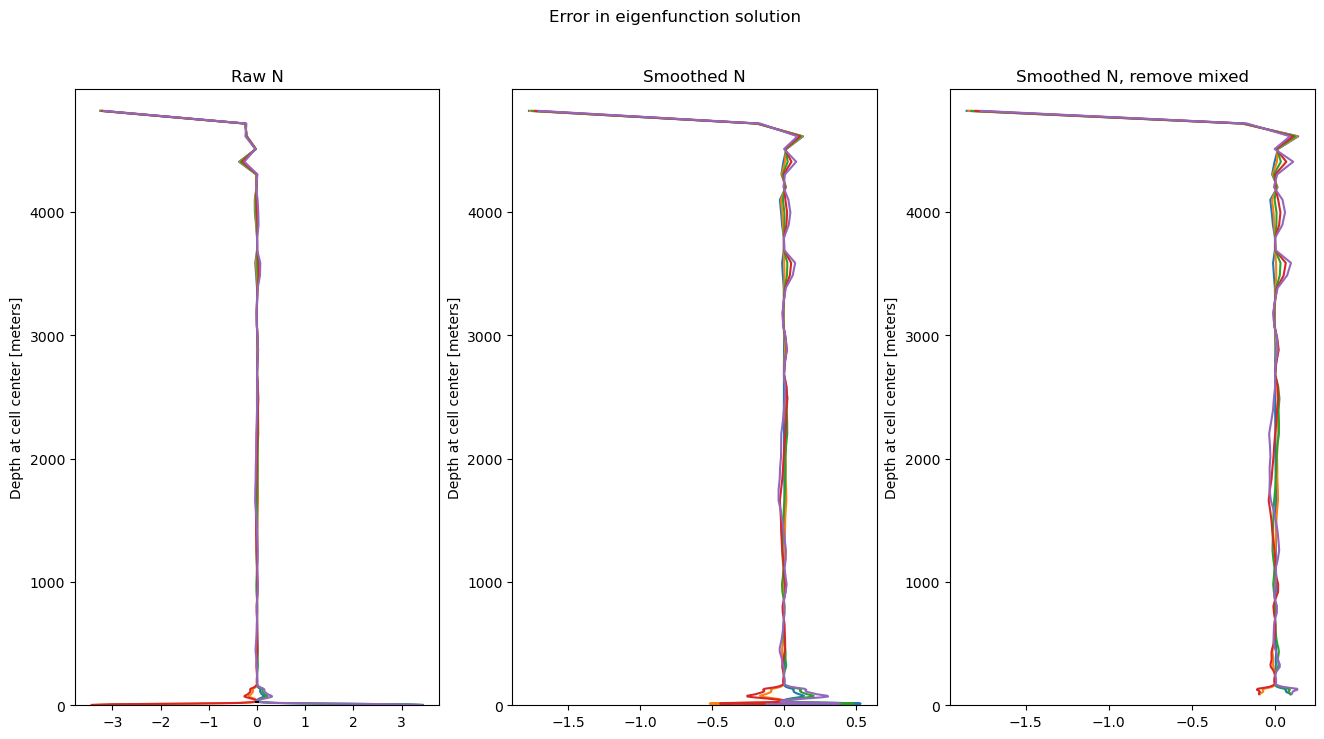

In [22]:
fig,ax = plt.subplots(1,3,figsize = (16,8))
H = to_process["ideal-20"]["data"].H.sel(xb = 800,yb = 0,method = "nearest")
N = to_process["ideal-20"]["data"].N.sel(xb = 800,yb = 0,method = "nearest")
for i in range(5):
    for j,data in enumerate([vmodes,vmodesSmooth,vmodesSmoothRemoveMixed]):
        phi = data.phi.sel(xb = 800,yb = 0,method = "nearest").isel(mode = i).sel(zl = slice(0,H))
        lhs = (N**(-2)).differentiate("zl") * phi.differentiate("zl") + phi*  N**2 * i**2 * np.pi**2 / H**2
        lhs.plot(ax = ax[j],y = "zl")

fig.suptitle("Error in eigenfunction solution")
ax[0].set_title("Raw N")
ax[1].set_title("Smoothed N")
ax[2].set_title("Smoothed N, remove mixed")
ax[0].set_ylim(0,H)
ax[2].set_ylim(0,H)
ax[1].set_ylim(0,H)
ax[2].set_ylim(0,H)
ax[0].hlines(30,-0.05,0.05,color = "black")

In [15]:
lhs

<xarray.DataArray (zl: 89, mode: 5)> Size: 4kB
dask.array<add, shape=(89, 5), dtype=float64, chunksize=(89, 5), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 712B 35.79 41.48 47.23 ... 4.822e+03 4.926e+03
    xb       float64 8B 800.0
    yb       float64 8B 0.0
    zi       float64 8B 10.79
    lon      float64 8B 156.0
    lat      float64 8B -45.67
Dimensions without coordinates: mode

In [10]:
lhs.values

array([[[0.        , 0.        , 0.        , ..., 4.38648939,
         4.97809458, 4.51133633],
        [0.        , 0.        , 0.        , ..., 5.69270992,
         5.39801359, 4.59025669],
        [0.        , 0.        , 0.        , ..., 4.63411093,
         5.14595175, 4.36395693],
        ...,
        [0.        , 0.        , 0.        , ..., 3.90842104,
         4.67998791, 4.90397453],
        [0.        , 0.        , 0.        , ..., 4.03021097,
         4.1721077 , 4.72781849],
        [0.        , 0.        , 0.        , ..., 4.08297634,
         4.13022709, 4.59017611]],

       [[0.        , 0.        , 0.        , ..., 3.63260317,
         4.02153015, 3.74510622],
        [0.        , 0.        , 0.        , ..., 4.3531208 ,
         4.17211866, 3.72230077],
        [0.        , 0.        , 0.        , ..., 3.82721472,
         4.09398031, 3.62598181],
        ...,
        [0.        , 0.        , 0.        , ..., 3.3502996 ,
         3.77169704, 3.96233058],
        [0. 

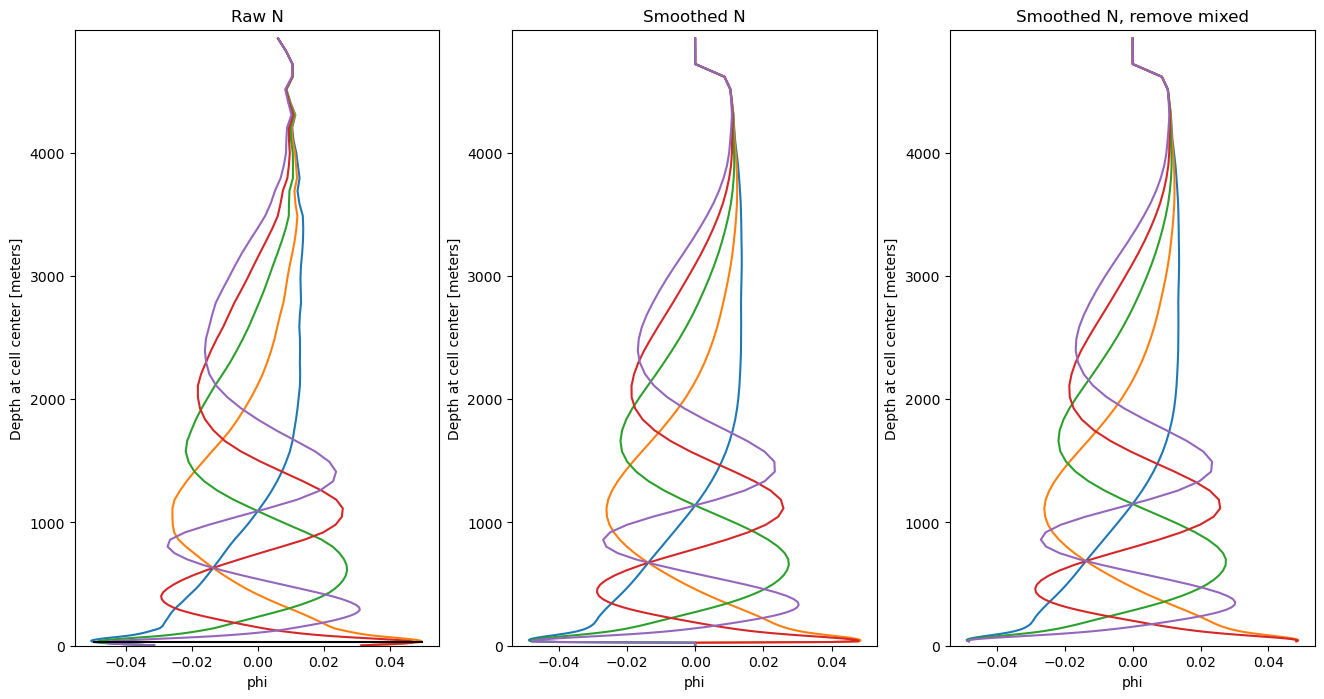

In [98]:
fig,ax = plt.subplots(1,3,figsize = (16,8))
H = to_process["ideal-20"]["data"].H.sel(xb = 800,yb = 0,method = "nearest")
for i in range(5):
    vmodes.phi.sel(xb = 800,yb = 0,method = "nearest").isel(mode = i).sel(zl = slice(0,H)).plot(ax = ax[0],y = "zl")
    vmodesSmooth.phi.sel(xb = 800,yb = 0,method = "nearest").isel(mode = i).sel(zl = slice(0,H)).plot(ax = ax[1],y = "zl")
    vmodesSmoothRemoveMixed.phi.sel(xb = 800,yb = 0,method = "nearest").isel(mode = i).sel(zl = slice(0,H)).plot(ax = ax[2],y = "zl")
ax[0].set_title("Raw N")
ax[1].set_title("Smoothed N")
ax[2].set_title("Smoothed N, remove mixed")
ax[0].set_ylim(0,H)
ax[2].set_ylim(0,H)
ax[1].set_ylim(0,H)
ax[2].set_ylim(0,H)
ax[0].hlines(30,-0.05,0.05,color = "black")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 39.59 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


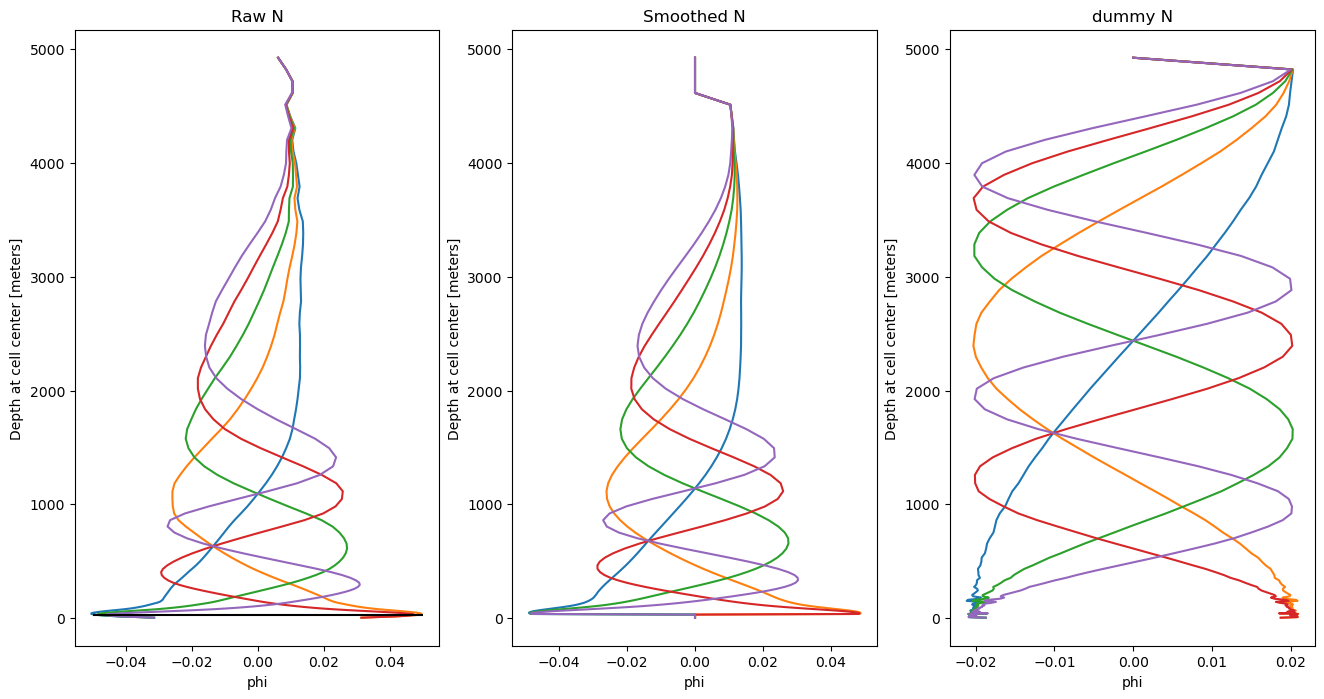

In [65]:
## Artificial phi

def LinearPhi(data):
    z = data.zl
    rhomax ,rhomin = np.max(data.rho),np.min(data.rho)
    m = (rhomax - rhomin ) / data.bathy

    rho = rhomin + m * z
    return rho.where(z < data.bathy,np.nan)

dummy = xr.Dataset(
    {i:to_process["ideal-20"]["data"][i] for i in to_process["ideal-20"]["data"]}
).transpose("time","xb","yb","zl")
dummy["rho"][:,:,:,:] = LinearPhi(dummy)

dummyvmodes = newVerticalModes(dummy,smoothing = False,ML_cutoff=0).load()


vmodes.phi.sel(xb = 800,yb = 0,method = "nearest").isel(mode = i).plot(ax = ax[0],y = "zl")


fig,ax = plt.subplots(1,3,figsize = (16,8))
H = to_process["ideal-20"]["data"].bathy.sel(xb = 800,yb = 0,method = "nearest")
for i in range(5):
    vmodes.phi.sel(xb = 800,yb = 0,method = "nearest").isel(mode = i).sel(zl = slice(0,H)).plot(ax = ax[0],y = "zl")
    vmodesSmooth.phi.sel(xb = 800,yb = 0,method = "nearest").isel(mode = i).sel(zl = slice(0,H)).plot(ax = ax[1],y = "zl")
    dummyvmodes.phi.sel(xb = 800,yb = 0,method = "nearest").isel(mode = i).sel(zl = slice(0,H)).plot(ax = ax[2],y = "zl")
ax[0].set_title("Raw N")
ax[1].set_title("Smoothed N")
ax[2].set_title("dummy N")
ax[0].hlines(30,-0.05,0.05,color = "black")

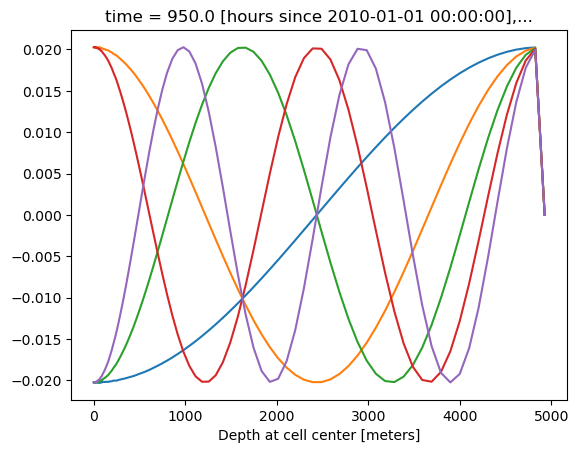

In [87]:

## Troubleshoot nmodes implementation



nmodes = 5
H = dummy.H.sel(xb = 800,yb = 0,method = "nearest")
zl = dummy.zl
rho = dummy.rho.sel(xb = 800,yb = 0,method = "nearest").isel(time = 0).where(dummy.zl < H,np.nan)

N = tt.calculate_N(rho)

def scipy_integrate(data):
    full_integral = scipy.integrate.trapezoid(data,x = zl)
    return (data * 0) + full_integral - scipy.integrate.cumulative_trapezoid(
        data,
        x = zl,
        initial = 0
        )


# Use np.apply_along_axis to prevent averaging over N and H!
eigenvectors = (rho * 0).expand_dims({"mode":nmodes})

## Construct empty arrays of the right dimensions to store the output

Nbar = N.integrate("zl") / H
for n in range(1,nmodes + 1): ## Start from 1 or else your first eigenfunction only depends on N!
    
    to_integrate = (n * N * np.pi) / (H * Nbar) ## This is the bit in the Approx Sturm-Liouville eqn under the integral sign within the cos term
    # This next line is a convuluted (but computationally efficient!) way of doing the cumulative sum along the z axis.
    integrated =  np.apply_along_axis(scipy_integrate,to_integrate.get_axis_num('zl'),to_integrate) 

    # This is just the rest of the eigenfunction. Fill NANs with 0s so that integrating over bathymetry doesn't cause problems.
    phi_n = (np.sqrt(
        2 * N / (H * Nbar)
    ) * np.cos(
        integrated
    )).fillna(0)
    phi_n.sel(zl = slice(0,H)).plot()
    eigenvectors[n-1,:] = phi_n

# plt.xlim(0,H)


In [103]:
ufiltered = filter(to_process["ideal-20"]["data"].u.sel(xb = slice(200,1200)).fillna(0))
# ufiltered.isel(time = 20).sel(xb = slice(0,1200)).isel(zl = 10).plot()

/jobfs/119611723.gadi-pbs/ipykernel_1991813/2429336988.py:84: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  u.drop(['lon', 'lat']).sel(xb = slice(200,1200)),dim = ["time","xb"]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [104]:
filtered_vmodes = (ufiltered.fillna(0).assign_coords({"time":vmodes.time,"xb":vmodes.sel(xb = slice(200,1200)).xb}) * vmodes.phi.sel(xb = slice(200,1200))).integrate("zl")
# filtered_vmodes

Text(0.5, 0.98, "Contours of mode 1 overlaid on higher mode. It's clear that mode 1 modulates the higher modes!")

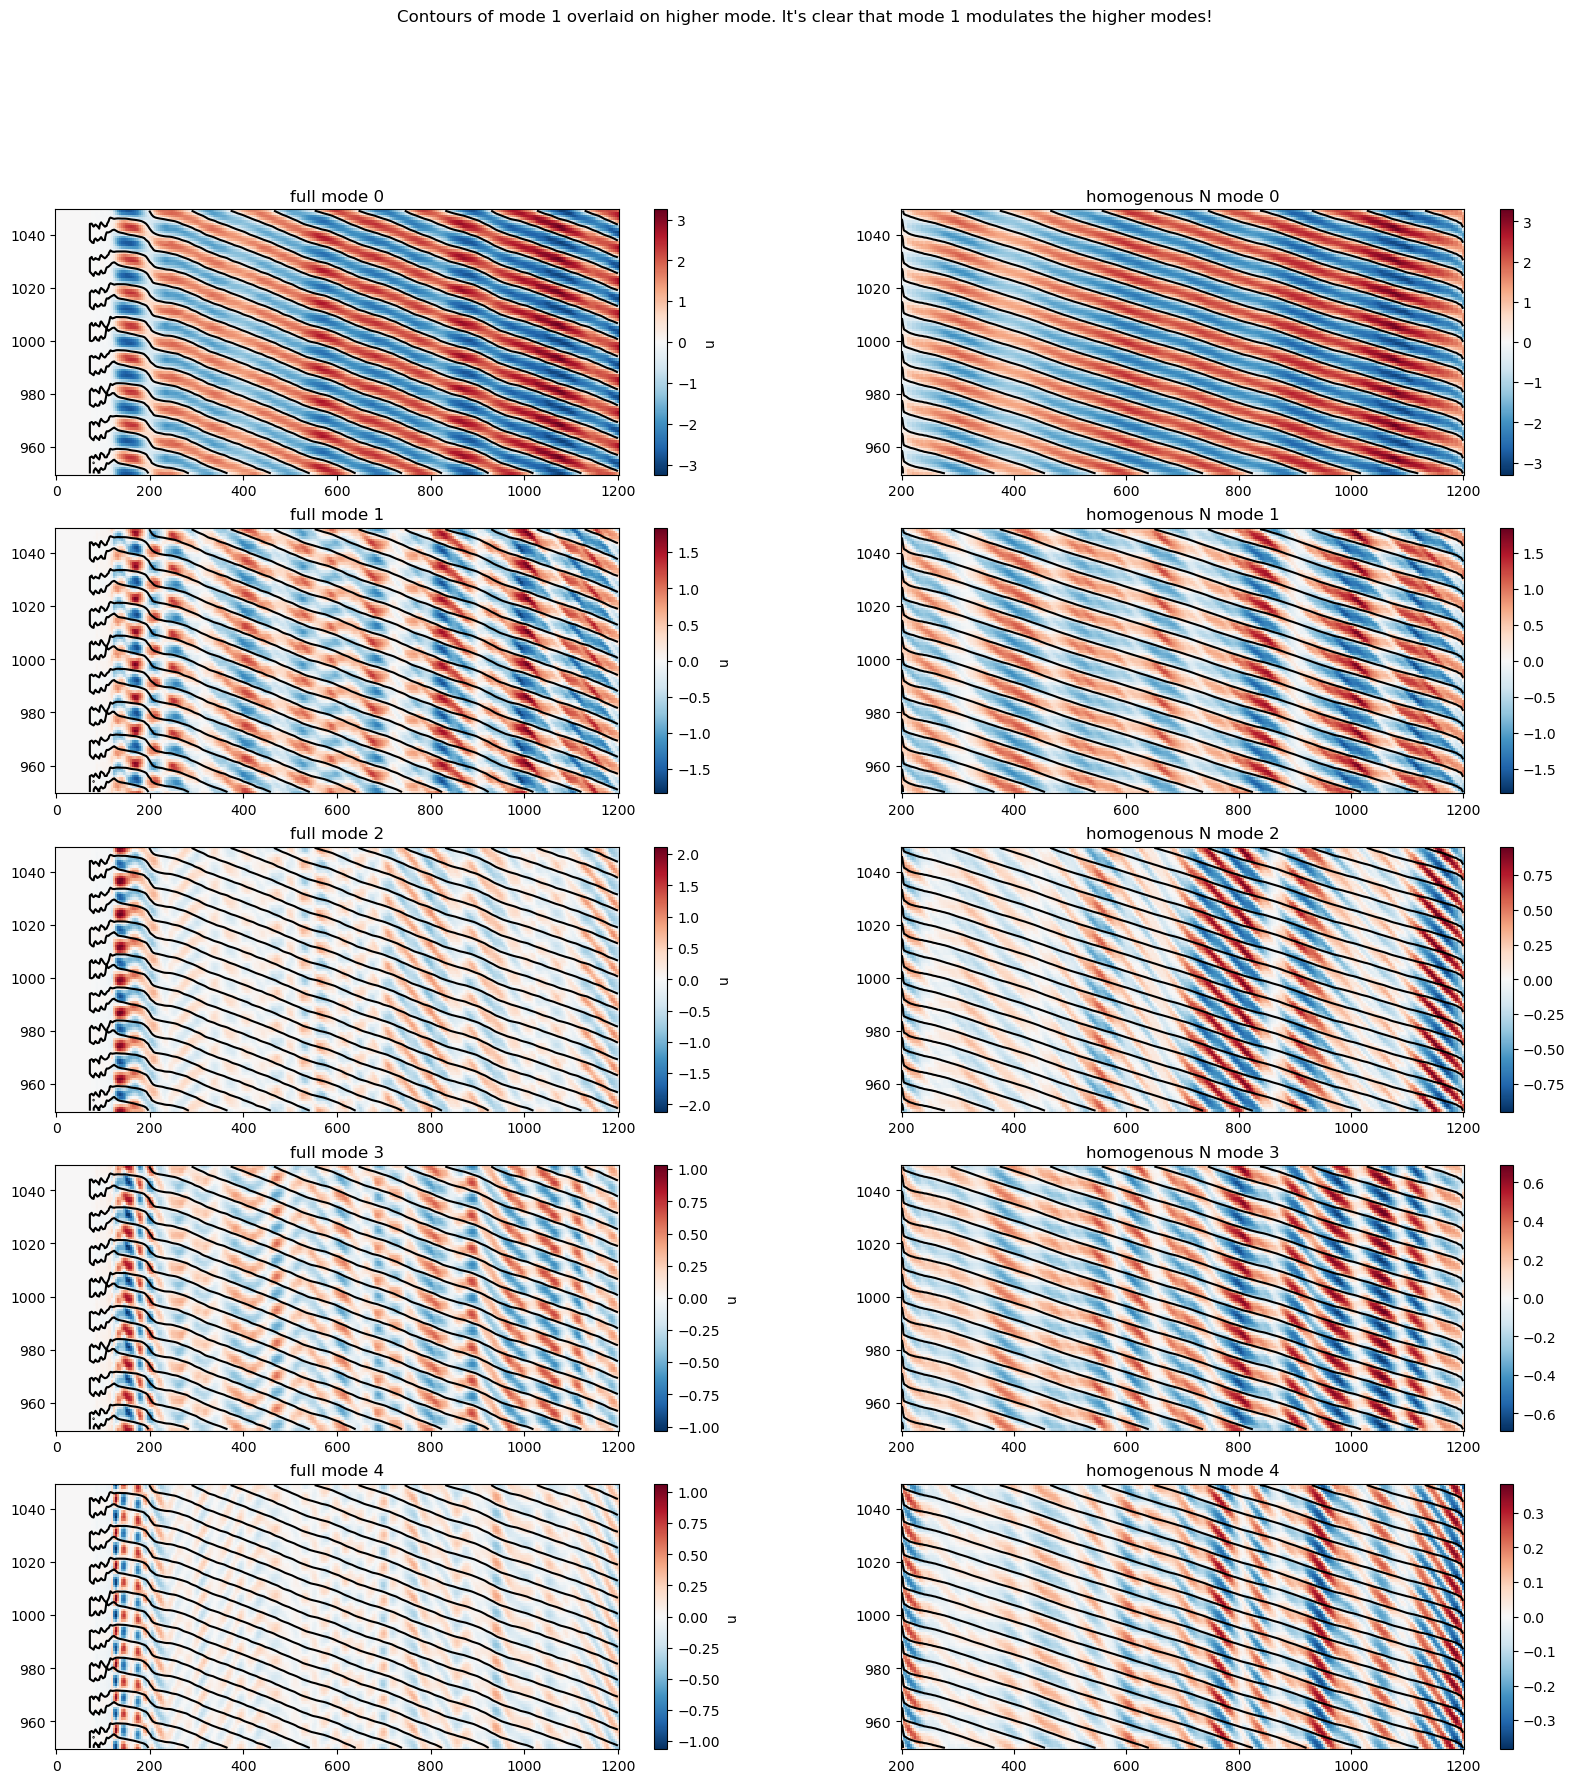

In [105]:
fig,ax = plt.subplots(5,2,figsize = (20,20))
for i in range(5):
    vmodesSmoothRemoveMixed.u.isel(mode=0).sel(xb =slice(0,1200)).sel(yb = 0,method = "nearest").plot.contour(levels = [0],ax= ax[i,0],cmap = "black")
    filtered_vmodes.isel(mode=0).sel(yb = 0,method = "nearest").plot.contour(levels = [0],ax= ax[i,1],cmap = "black")

    # filtered = (ufiltered * vmodes.phi).sel(xb =slice(0,1200)).sel(yb = 0,method = "nearest")

    vmodesSmoothRemoveMixed.u.isel(mode=i).sel(xb =slice(0,1200)).sel(yb = 0,method = "nearest").plot(ax= ax[i,0])
    filtered_vmodes.isel(mode=i).sel(yb = 0,method = "nearest").plot(ax= ax[i,1])
    ax[i,0].set_xlabel("")
    ax[i,0].set_title(f"full mode {i}")
    ax[i,1].set_xlabel("")
    ax[i,0].set_ylabel("")
    ax[i,1].set_title(f"homogenous N mode {i}")
    ax[i,1].set_ylabel("")

fig.suptitle("Contours of mode 1 overlaid on higher mode. It's clear that mode 1 modulates the higher modes!")